# Session 3 – UK Respiratory Deaths

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/ShamsaraE/time-series-medicine-biology-2026/blob/main/notebooks/03_uk_respiratory_deaths_Deterministic_Stochastic_model.ipynb
)

## Deterministic Seasonality → Stochastic Dependence → SARIMA Modeling


You will learn to:
1. Visualize seasonality and short-term dependence
2. Remove deterministic seasonality (harmonic regression, STL)
3. Diagnose remaining autocorrelation (ACF/PACF, Ljung–Box)
4. Check stationarity (ADF + KPSS)
5. Remove seasonality via seasonal differencing
6. Identify and fit a SARIMA model
7. Validate residuals and forecast


## 0. Imports

We load tools for:
- regression and decomposition
- ACF/PACF diagnostics
- stationarity tests
- SARIMA modeling (SARIMAX in statsmodels)


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX


## 0.1 Big Picture (Concept Map)

Raw time series typically contains:

$
\text{Data} =
\underbrace{\text{deterministic structure}}_{\text{seasonality/trend}}
+
\underbrace{\text{stochastic structure}}_{\text{autocorrelation}}
+
\underbrace{\text{noise}}_{\text{unpredictable}}
$

**Workflow**
1) plot and inspect  
2) quantify dependence (lag scatter, ACF/PACF)  
3) remove deterministic seasonality  
4) check if residuals look like white noise  
5) if not, fit stochastic model (SARIMA)


## 1. Load Data


We analyze monthly respiratory deaths in the UK (1974–1979) for:
- male (`mdeaths`)
- female (`fdeaths`)



In [20]:
fdeaths_url = 'https://vincentarelbundock.github.io/Rdatasets/csv/datasets/fdeaths.csv'
mdeaths_url = 'https://vincentarelbundock.github.io/Rdatasets/csv/datasets/mdeaths.csv'

female = pd.read_csv(fdeaths_url, index_col=0)['value']
male = pd.read_csv(mdeaths_url, index_col=0)['value']

dates = pd.date_range(start='1974-01-01', periods=len(male), freq='M')
male.index = dates
female.index = dates

male.head()


1974-01-31    2134
1974-02-28    1863
1974-03-31    1877
1974-04-30    1877
1974-05-31    1492
Freq: M, Name: value, dtype: int64

### Interpretation
If `male.head()` shows dates like `1974-01-31`, `1974-02-28`, ... the time index is correct.


## 2. Plot the Series

### Why?
Visualization answers the first questions:
- Is there seasonality?
- Is there a trend?
- Is variance constant?


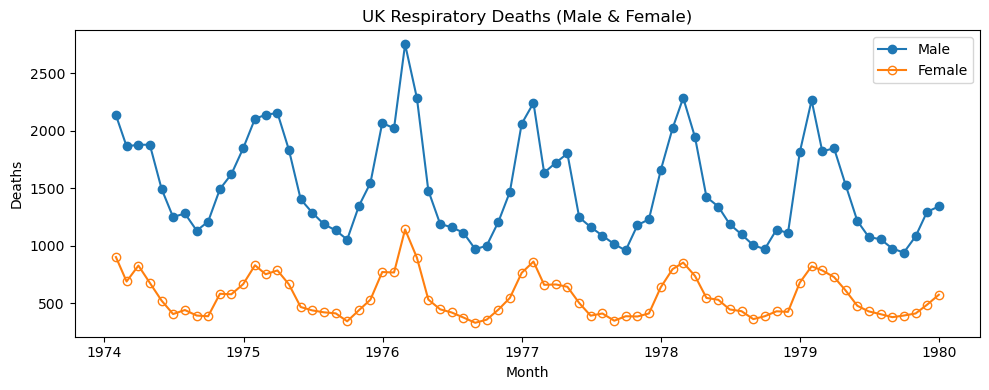

In [21]:
plt.figure(figsize=(10,4))
plt.plot(male, marker='o', label='Male')
plt.plot(female, marker='o', markerfacecolor='none', label='Female')
plt.title("UK Respiratory Deaths (Male & Female)")
plt.xlabel("Month")
plt.ylabel("Deaths")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation
Observations in this dataset:

- Clear yearly oscillation → **strong annual seasonality**
- Winter peaks are higher → consistent with respiratory disease patterns
- Male series has higher baseline than female


## Autocovariance

### Mathematical Definition

For a weakly stationary time series $ X_t $ with mean $ \mu = E[X_t] $,

$
\gamma(k) = \text{Cov}(X_t, X_{t-k})
$

Equivalently,

$
\gamma(k) = E[(X_t - \mu)(X_{t-k} - \mu)]
$

### What Does This Formula Say?

- If both $X_t$ and $X_{t-k}$ are above the mean → product positive  
- If both are below the mean → product positive  
- If one is above and one below → product negative  

So:

- $ \gamma(k) > 0 $ → persistence  
- $ \gamma(k) < 0 $ → oscillation  
- $ \gamma(k) = 0 $ → no linear dependence  

### Statistical Meaning

Autocovariance measures how much the present value moves together with its past.

It quantifies **memory in the time series**.

### Biological Interpretation

If $X_t$ represents monthly respiratory deaths:

- $ \gamma(1) > 0 $ means high mortality this month tends to be followed by high mortality next month → epidemic persistence.

- $ \gamma(12) > 0 $ means this January resembles last January → seasonal recurrence.

Autocovariance measures biological memory across time.

## Autocorrelation Function (ACF)

### Mathematical Definition

$
\rho(k) = \frac{\gamma(k)}{\gamma(0)}
$

where

$
\gamma(0) = \text{Var}(X_t)
$

### What Does This Mean?

Autocorrelation is just normalized autocovariance.

Properties:

- $ \rho(0) = 1 $
- $ -1 \le \rho(k) \le 1 $

It measures correlation between present and past values.

### Statistical Meaning

ACF tells us:

How strongly does the current value depend on values k steps back?

- Slow decay → long memory  
- Fast drop → short memory  
- Seasonal spikes → recurring yearly dependence  

### Biological Interpretation

If $ \rho(1) = 0.6 $:

Current month’s deaths are strongly linked to last month’s deaths.

In epidemics:

- Transmission chains create short-term dependence.
- Hospital load depends on recent hospital load.

ACF measures transmission persistence.

## 3. Lag-1 Scatter Plot (Visual Autocorrelation)


A lag-1 scatter plots $(X_{t-1}, X_t)$.
If points align along a diagonal → strong lag-1 autocorrelation.

This is a geometric view of $\rho(1)$.


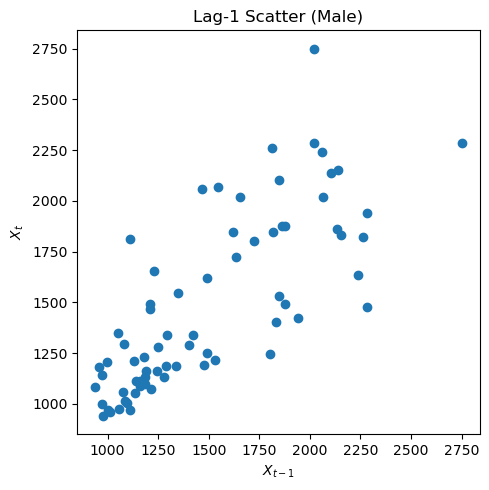

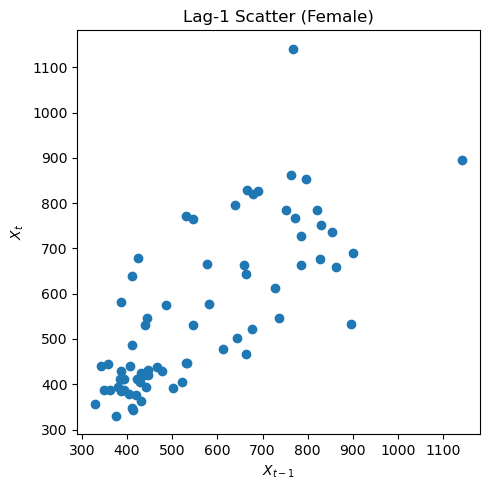

In [36]:
def lag_scatter(series: pd.Series, title: str):
    x_tm1 = series.values[:-1]
    x_t = series.values[1:]
    plt.figure(figsize=(5,5))
    plt.scatter(x_tm1, x_t)
    plt.xlabel(r"$X_{t-1}$")
    plt.ylabel(r"$X_t$")
    plt.title(title)
    plt.tight_layout()
    plt.show()

lag_scatter(male, "Lag-1 Scatter (Male)")
lag_scatter(female, "Lag-1 Scatter (Female)")


### Interpretation
- A strong diagonal cloud means: high deaths one month tend to be followed by high deaths next month.
- However, this dependence can be partly **seasonal** (winter months follow winter months).

So we next remove deterministic seasonality and re-check dependence.


## 4. Remove Deterministic Seasonality: Harmonic Regression

We model a smooth annual cycle using sine/cosine terms:

\begin{align}
X_t &= \beta_0 + \beta_1 \sin(2\pi t/12) + \beta_2 \cos(2\pi t/12) + \varepsilon_t
\end{align}

### Why?
To remove deterministic seasonal structure so that the residuals represent
the **stochastic component** (plus noise).


In [23]:
def harmonic_regression(series: pd.Series, period: int = 12):
    t = np.arange(len(series))
    sin_term = np.sin(2 * np.pi * t / period)
    cos_term = np.cos(2 * np.pi * t / period)
    X = np.column_stack([sin_term, cos_term])
    X = sm.add_constant(X)
    model = sm.OLS(series.values, X).fit()
    fitted = model.predict(X)
    resid = series.values - fitted
    return model, fitted, resid

male_harm_model, male_harm_fit, male_harm_resid = harmonic_regression(male, period=12)
female_harm_model, female_harm_fit, female_harm_resid = harmonic_regression(female, period=12)

male_harm_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     131.4
Date:                Sun, 22 Feb 2026   Prob (F-statistic):           2.93e-24
Time:                        10:40:18   Log-Likelihood:                -482.24
No. Observations:                  72   AIC:                             970.5
Df Residuals:                      69   BIC:                             977.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1495.9444     23.611     63.357      0.000    1448.841    1543.047
x1           233.3146     33.391      6.987      0.000     166.701     299.928
x2           488.5270     33.391     14.630      0.000     421.913     555.141
==============================================================================
Omnibus:                        5.392   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                6.296
Skew:                           0.271   Prob(JB):                       0.0429
Kurtosis:                       4.343   Cond. No.                         1.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation of the Regression Summary

Key lines:

- **R-squared = 0.792** → about **79%** of the variance is explained by a simple annual sinusoid (seasonality dominates).
- **Prob(F-statistic) = 2.93e-24** → overwhelmingly strong evidence that the seasonal terms matter (reject “no seasonality”).
- **Durbin–Watson = 1.253** → residuals still show **positive autocorrelation** (DW < 2).

Conclusion:
Seasonality is captured well, but residuals are not independent → we must analyze stochastic dependence next.



### Seasonal Amplitude

The sine/cosine coefficients can be converted into an amplitude:

\begin{align}
A &= \sqrt{\beta_1^2 + \beta_2^2}
\end{align}

Interpretation:
$A$ is the approximate size of the seasonal swing around the mean level.


In [24]:
b0, b1, b2 = male_harm_model.params
A = np.sqrt(b1**2 + b2**2)
A


541.3818891365786

### Interpretation
$A$ is the estimated magnitude of the annual seasonal swing.
For example, if $A\approx 540$, deaths typically fluctuate by roughly ±540 around the mean due to seasonality.


## 4.1 Plot: Original vs Harmonic Seasonal Fit


To visually confirm that the sinusoid tracks the annual peaks/troughs.


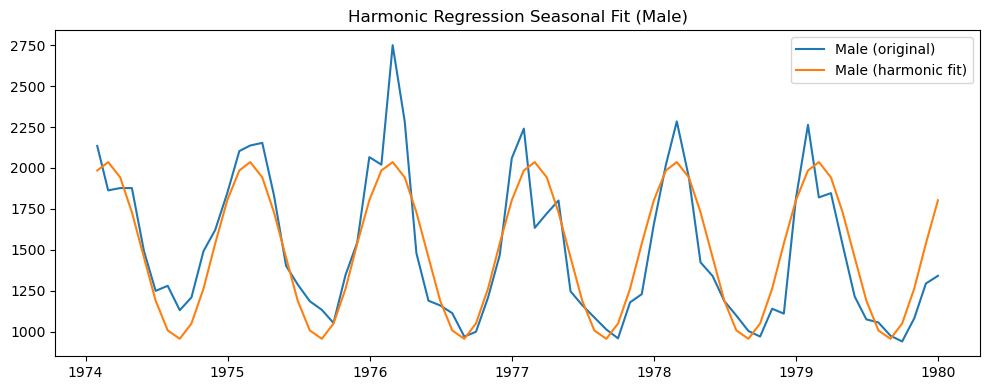

In [25]:
plt.figure(figsize=(10,4))
plt.plot(male.index, male.values, label="Male (original)")
plt.plot(male.index, male_harm_fit, label="Male (harmonic fit)")
plt.title("Harmonic Regression Seasonal Fit (Male)")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation of output
If the fitted curve follows the repeating yearly ups/downs, deterministic seasonality is captured.
The remaining deviations are the residuals (candidate stochastic component + noise).


## 4.2 Residual Time Plot


Residual plots help detect:
- remaining structure (runs, cycles)
- outliers (unexpected spikes)
- variance changes (heteroskedasticity)


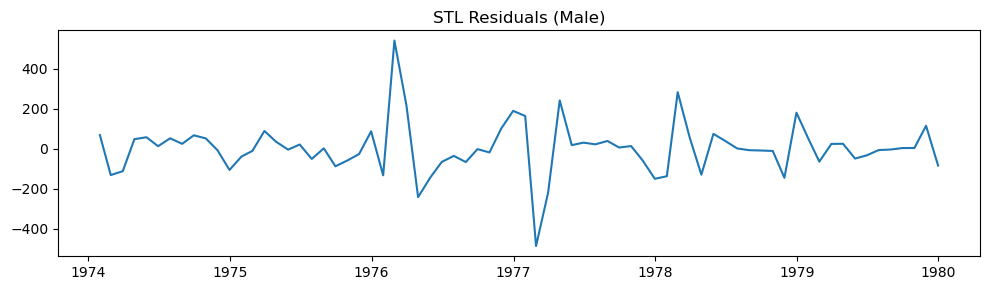

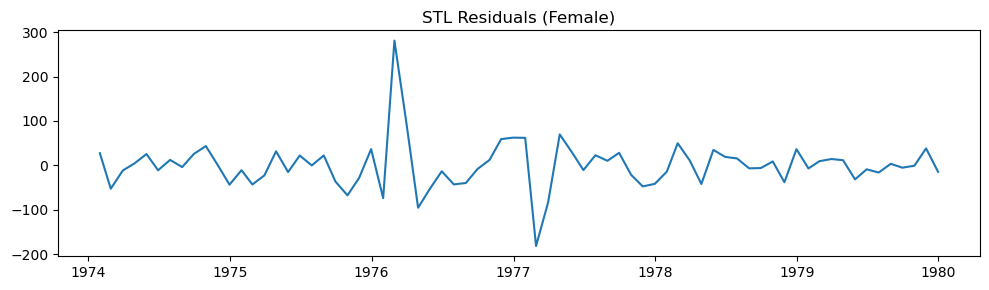

In [32]:
stl_male = STL(male, period=12).fit()
stl_female = STL(female, period=12).fit()

plt.figure(figsize=(10,3))
plt.plot(stl_male.resid)
plt.title("STL Residuals (Male)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(stl_female.resid)
plt.title("STL Residuals (Female)")
plt.tight_layout()
plt.show()



### Interpretation of output
Your STL residual plot highlights notable deviations (e.g., around 1976 and 1977), suggesting:
- occasional shocks/outliers beyond smooth seasonality
- potential remaining autocorrelation

We still need formal tests (ACF + Ljung–Box).


## 5. Lag-1 Scatter After Seasonality Removal

### Why?
To test whether lag-1 dependence was mainly seasonal.


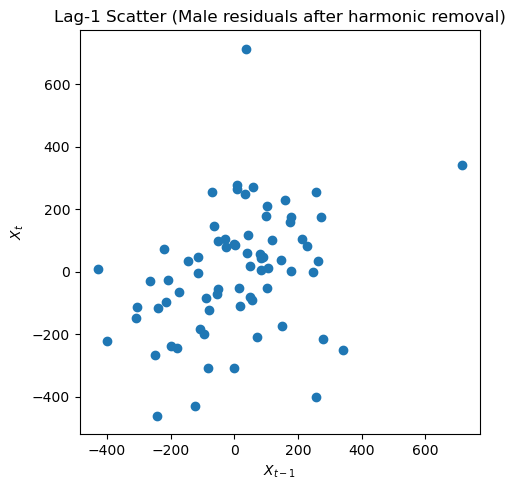

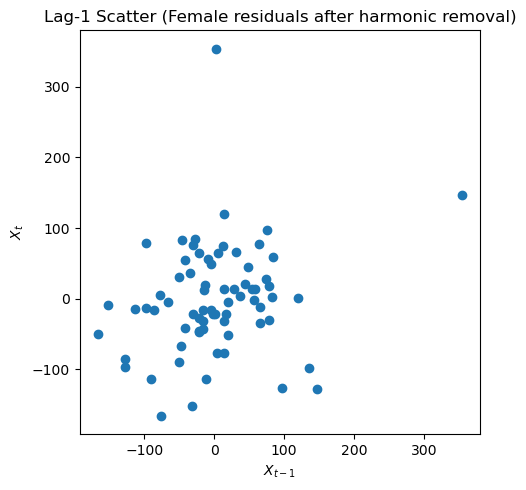

In [27]:
lag_scatter(pd.Series(male_harm_resid), "Lag-1 Scatter (Male residuals after harmonic removal)")
lag_scatter(pd.Series(female_harm_resid), "Lag-1 Scatter (Female residuals after harmonic removal)")


### Interpretation
If the diagonal structure shrinks vs the original lag plot → much of the dependence was seasonal.
If a diagonal remains → stochastic persistence beyond seasonality remains.


## 6. STL Decomposition (Flexible Seasonality)


Harmonic regression assumes a fixed sinusoidal shape.
STL can capture changing seasonal shapes/amplitudes.


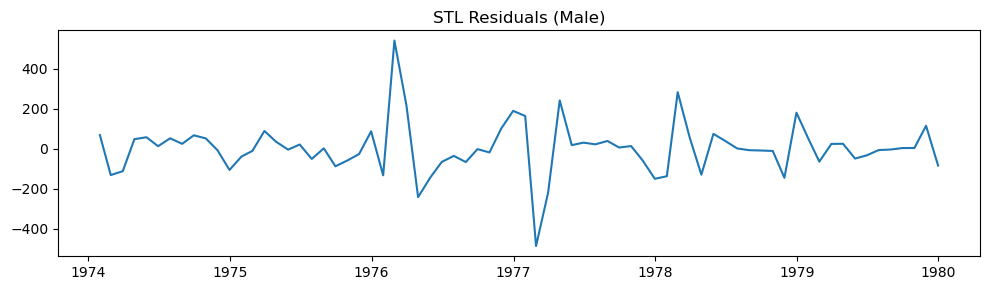

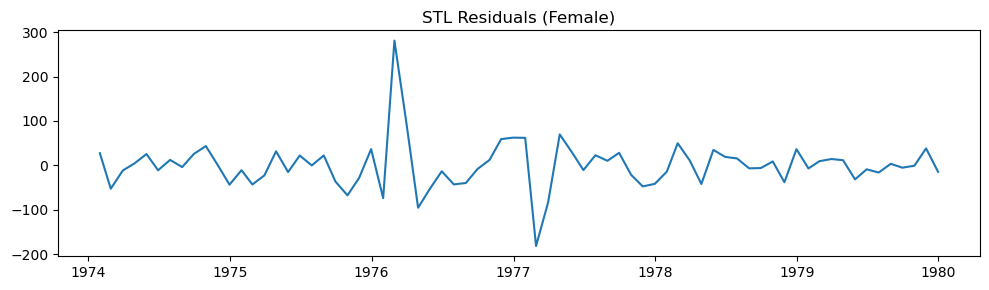

In [28]:
stl_male = STL(male, period=12).fit()
stl_female = STL(female, period=12).fit()

plt.figure(figsize=(10,3))
plt.plot(stl_male.resid)
plt.title("STL Residuals (Male)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(stl_female.resid)
plt.title("STL Residuals (Female)")
plt.tight_layout()
plt.show()


### Interpretation
If STL residuals look more random than harmonic residuals, STL removed seasonality more effectively.
But we still need formal diagnostics.


## 7. White Noise Diagnostics (ACF + Ljung–Box)

### Why?
A good model should leave residuals that are approximately white noise.

We use:
- ACF plot (visual)
- Ljung–Box test (formal test up to chosen lag)

Ljung–Box $H_0$: residuals have no autocorrelation up to the chosen lag.


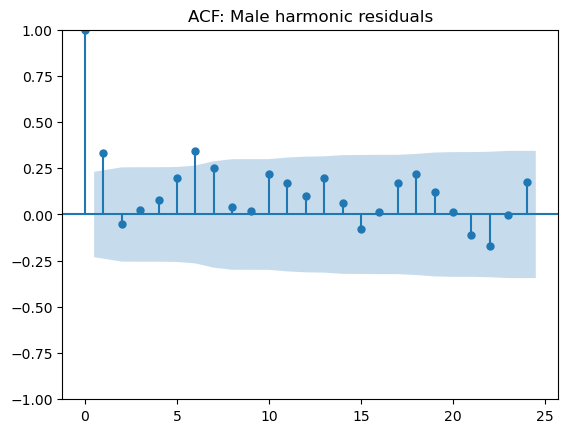

,lb_stat,lb_pvalue
12,34.46836,0.000569


In [29]:
plot_acf(male_harm_resid, lags=24)
plt.title("ACF: Male harmonic residuals")
plt.show()

acorr_ljungbox(male_harm_resid, lags=[12], return_df=True)


### Interpretation
- ACF spikes outside band → autocorrelation remains.
- Ljung–Box p < 0.05 → reject white noise → dependence remains.
This motivates SARIMA modeling.


## 8. Stationarity (ADF + KPSS)

### Why?
SARIMA assumes stationarity after differencing.

Two complementary tests:
- ADF: $H_0$ = unit root (nonstationary)
- KPSS: $H_0$ = stationary


In [30]:
def stationarity_tests(series: pd.Series, name: str):
    s = series.dropna()
    adf_p = adfuller(s)[1]
    kpss_p = kpss(s, regression='c', nlags='auto')[1]
    print(f"{name}")
    print(f"  ADF  p-value (H0: unit root):  {adf_p:.4f}")
    print(f"  KPSS p-value (H0: stationary): {kpss_p:.4f}")
    print()

stationarity_tests(male, "Male (raw)")
stationarity_tests(female, "Female (raw)")


Male (raw)
  ADF  p-value (H0: unit root):  0.9293
  KPSS p-value (H0: stationary): 0.1000

Female (raw)
  ADF  p-value (H0: unit root):  0.5135
  KPSS p-value (H0: stationary): 0.1000



/opt/anaconda3/envs/sql/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/opt/anaconda3/envs/sql/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Interpretation
Raw series results:
- Male: ADF p = 0.9293 (cannot reject nonstationarity), KPSS p ≈ 0.10 (do not reject stationarity)
- Female: ADF p = 0.5135, KPSS p ≈ 0.10

This “mixed message” is common with seasonal data and small samples.
Most importantly, the plots already showed strong seasonality, so we apply **seasonal differencing**.


## Seasonal Differencing

For seasonal period s:

$
\nabla_s X_t = X_t - X_{t-s}
$

For monthly data:

$
\nabla_{12} X_t = X_t - X_{t-12}
$

### What Does This Do?

Subtracts same month last year.

Removes repeating seasonal mean structure.

### Biological Interpretation

If January is always high due to winter viruses:

Seasonal differencing removes that systematic effect.

What remains is unexpected variation and short-term dynamics.

## 9. Seasonal Differencing (Period = 12)

For monthly data, annual seasonality can be removed by seasonal differencing:

\begin{align}
\nabla_{12} X_t &= X_t - X_{t-12}
\end{align}

### Why?
This subtracts "same month last year" and removes a repeating yearly pattern.


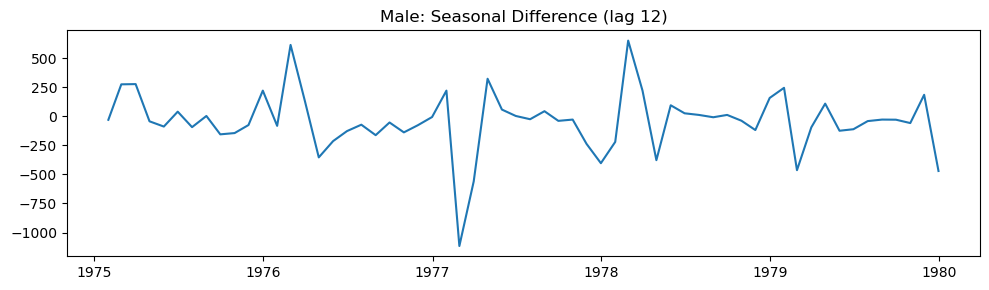

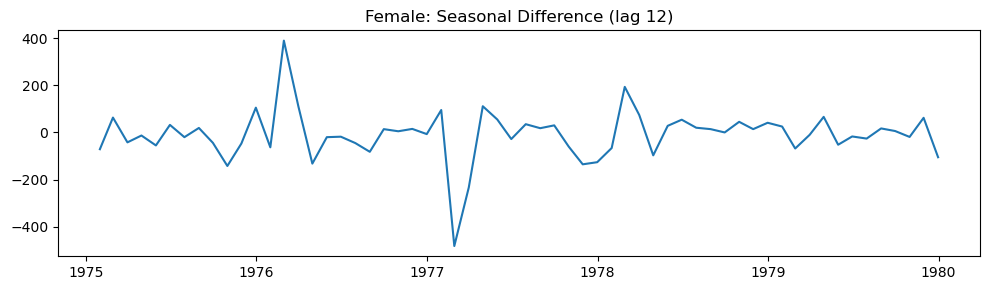

Male (seasonally differenced)
  ADF  p-value (H0: unit root):  0.3031
  KPSS p-value (H0: stationary): 0.1000

Female (seasonally differenced)
  ADF  p-value (H0: unit root):  0.0980
  KPSS p-value (H0: stationary): 0.1000



/opt/anaconda3/envs/sql/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/opt/anaconda3/envs/sql/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [33]:
male_seasdiff = male.diff(12).dropna()
female_seasdiff = female.diff(12).dropna()

plt.figure(figsize=(10,3))
plt.plot(male_seasdiff)
plt.title("Male: Seasonal Difference (lag 12)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(female_seasdiff)
plt.title("Female: Seasonal Difference (lag 12)")
plt.tight_layout()
plt.show()

stationarity_tests(male_seasdiff, "Male (seasonally differenced)")
stationarity_tests(female_seasdiff, "Female (seasonally differenced)")


### Why Do ADF and KPSS Give Mixed Results?

Seasonal cycles can mimic nonstationarity.

ADF tests for a stochastic trend (unit root).
Seasonality is deterministic but repeating.

Thus:
ADF may fail to reject unit root,
even though the main issue is seasonal structure.

This is why we visually inspect the plot
and apply seasonal differencing.

### Interpretation
After seasonal differencing, the mean is often more stable.
If stationarity improves, we can model remaining short-lag dependence with ARMA terms.


## Autoregressive Model AR(p)

### Mathematical Definition

$
X_t = \phi_1 X_{t-1} + \dots + \phi_p X_{t-p} + \varepsilon_t
$

where $ \varepsilon_t \sim WN(0, \sigma^2) $.

### Special Case: AR(1)

$
X_t = \phi X_{t-1} + \varepsilon_t
$

Stationary if $ |\phi| < 1 $.

### Theoretical ACF of AR(1)

$
\rho(k) = \phi^k
$

This means autocorrelation decays geometrically.

### Statistical Meaning

AR models represent persistence:

Current value depends directly on past values.

### Biological Interpretation

If $ \phi = 0.8 $:

A surge in deaths this month strongly increases deaths next month,
but effect weakens over time.

AR captures epidemic persistence.

## Partial Autocorrelation Function (PACF)

### Mathematical Definition

PACF at lag k is the last coefficient in the regression:

$
X_t = \phi_{k1}X_{t-1} + \dots + \phi_{kk}X_{t-k} + \varepsilon_t
$

The PACF value equals $ \phi_{kk} $.

### What Does This Mean?

PACF measures:

The direct effect of lag k after removing the effects of lags 1,...,k−1.

ACF includes both direct and indirect effects.
PACF isolates the direct influence.

### Statistical Meaning

If PACF cuts off after lag p:

→ The process behaves like AR(p).

### Biological Interpretation

If PACF cuts off after lag 1:

Only the previous month directly influences the current month.

Two months ago matters only indirectly through last month.

PACF detects the direct biological influence window.

## Moving Average Model MA(q)

### Mathematical Definition

$
X_t = \varepsilon_t + \theta_1 \varepsilon_{t-1} + \dots + \theta_q \varepsilon_{t-q}
$

### Statistical Properties

- ACF cuts off after lag q.
- PACF decays gradually.

### Statistical Meaning

Current value depends on past shocks, not past values.

### Biological Interpretation

If a severe winter shock affects deaths for two months but disappears after that:

This resembles an MA(2) process.

MA captures finite-duration shocks.

## 9.1 ACF/PACF After Seasonal Differencing

### Why?
ACF/PACF guide choice of AR (p) and MA (q) terms for the non-seasonal part,
and P/Q for the seasonal part.

Heuristics:
- AR(p): PACF cuts off after p; ACF decays.
- MA(q): ACF cuts off after q; PACF decays.
- Seasonal spikes at 12,24,... suggest seasonal terms.


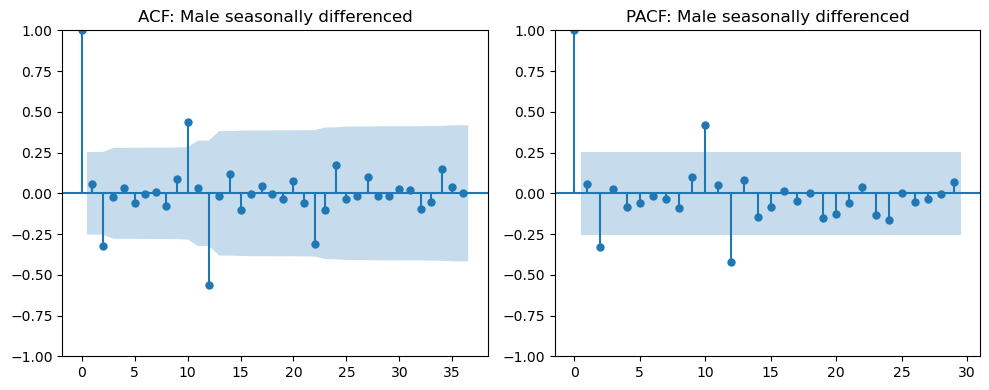

In [34]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
plot_acf(male_seasdiff, lags=36, ax=ax1)
ax1.set_title("ACF: Male seasonally differenced")

ax2 = fig.add_subplot(1,2,2)
n = len(male_seasdiff)
max_lag = min(36, n//2 - 1)
plot_pacf(male_seasdiff, lags=max_lag, ax=ax2, method='ywm')
ax2.set_title("PACF: Male seasonally differenced")



plt.tight_layout()
plt.show()


### Interpretation (Male, Seasonally Differenced)

1. Short lags (1–6):
   - Lag 1 shows moderate positive correlation.
   - Decay appears gradual rather than sharp cutoff.
   → Suggests AR-type persistence.

2. Seasonal lag (12):
   - Visible spike around lag 12.
   → Indicates remaining seasonal dependence.



# How to Read ACF and PACF Plots

Before fitting any ARIMA or SARIMA model, we must understand
what the ACF and PACF plots are actually showing.

---

## 1. What Is Plotted on the Axes?

### Horizontal axis (x-axis):
Lag k

- Lag 1 → relationship with previous time step
- Lag 2 → relationship with two time steps ago
- Lag 12 (monthly data) → relationship with same month last year

### Vertical axis (y-axis):
Autocorrelation value

\[
\rho(k) = \text{Corr}(X_t, X_{t-k})
\]

Each vertical bar represents the sample autocorrelation at lag k.

---

## 2. What Do the Blue Confidence Bands Mean?

The dashed horizontal lines represent approximately:

\[
\pm \frac{2}{\sqrt{n}}
\]

If a bar exceeds these bounds:

→ The correlation is statistically different from zero (approximately at 5% level).

Important:
A few random spikes are normal.
Consistent patterns are meaningful.

---

## 3. Reading the ACF Plot

The ACF shows total correlation between present and past.

### What to look for:

### (A) Slow geometric decay
- Bars gradually shrink toward zero
→ Suggests AR-type behavior

### (B) Sharp cutoff after lag q
- Significant at lags 1,...,q
- Then near zero afterwards
→ Suggests MA(q)

### (C) Seasonal spikes
- Large spikes at lag 12, 24, 36
→ Suggests seasonal structure

---

## 4. Reading the PACF Plot

The PACF shows direct correlation at each lag.

### What to look for:

### (A) Sharp cutoff after lag p
- Significant at lags 1,...,p
- Then near zero afterwards
→ Suggests AR(p)

### (B) Gradual decay
→ Suggests MA-type behavior

---

## 5. AR vs MA Identification Rules

| Pattern | Likely Model |
|----------|--------------|
| ACF decays slowly, PACF cuts off at p | AR(p) |
| ACF cuts off at q, PACF decays slowly | MA(q) |
| Both decay slowly | ARMA |

These are heuristics, not strict laws.

---

## 6. Seasonal Interpretation (Monthly Data)

For monthly data (s = 12):

### If ACF shows spike at lag 12:
→ Seasonal dependence exists.

### If PACF shows spike at lag 12:
→ Seasonal AR term may be needed.

### If ACF shows spike at 12 and cuts off:
→ Seasonal MA term may be needed.

Seasonal memory means:

The value this month resembles the same month last year.

---

## 7. Biological Interpretation

ACF and PACF measure biological memory.

In respiratory mortality:

- Lag 1 correlation:
  Transmission persistence across months.

- Lag 2–3 correlation:
  Short-term epidemic dynamics.

- Lag 12 correlation:
  Winter-to-winter similarity.

If correlations decay slowly:
The epidemic shock fades gradually.

If correlations cut off sharply:
Shocks have limited duration.

---

## 8. Important Warning

ACF/PACF patterns are guides — not guarantees.

Always:
1. Propose a model.
2. Fit it.
3. Check residual ACF.
4. Use Ljung–Box test.

Diagnostics determine model adequacy.

## SARIMA(p,d,q)(P,D,Q)_s

### Meaning of Parameters

- p: short-term AR order
- d: regular differencing
- q: short-term MA order
- P: seasonal AR order
- D: seasonal differencing
- Q: seasonal MA order
- s: seasonal period (12 for monthly)

### Full Model (Operator Form)

$
\Phi(B^s)\phi(B)(1-B)^d (1-B^s)^D X_t =
\Theta(B^s)\theta(B)\varepsilon_t
$

where B is the backshift operator.

### Statistical Meaning

SARIMA models:

- short-term persistence
- seasonal recurrence
- temporary shocks
- trend removal

### Biological Interpretation

In respiratory mortality:

- AR → month-to-month persistence
- MA → temporary shock effects
- Seasonal AR → similarity between same months across years
- Seasonal MA → propagation of yearly shocks

SARIMA models both epidemic memory and seasonal recurrence.

## 10. Fit a SARIMA Model (via SARIMAX)

We start with a common baseline for monthly seasonal data:

\begin{align}
SARIMA(1,0,0)(1,1,0)_{12}
\end{align}

### Why this structure?
- \(D=1\): seasonal differencing handles annual cycle
- \(p=1\): captures month-to-month persistence
- \(P=1\): captures year-to-year persistence not fully removed


In [15]:
sarima_110 = SARIMAX(
    male,
    order=(1,0,0),
    seasonal_order=(1,1,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarima_110.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   72
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -320.845
Date:                            Sun, 22 Feb 2026   AIC                            647.691
Time:                                    10:18:16   BIC                            653.241
Sample:                                01-31-1974   HQIC                           649.779
                                     - 12-31-1979                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3065      0.173      1.776      0.076      -0.032       0.645
ar.S.L12      -0.6876      0.089     -7.712      0.000      -0.862      -0.513
sigma2      4.977e+04   6462.819      7.701      0.000    3.71e+04    6.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                79.20
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Interpretation of SARIMA Summary

Look at:
1) **AIC/BIC**: compare across SARIMA candidates; lower is better.
2) **AR(1)** term: significant positive → short-memory persistence.
3) **Seasonal AR(1)** term: significant → yearly persistence.
4) Residual diagnostics: must look close to white noise.


# Full Interpretation of SARIMA(1,0,0)(1,1,0)_12

We fitted the model:

$
SARIMA(1,0,0)(1,1,0)_{12}
$

This means:

- p = 1 → short-term AR(1)
- d = 0 → no regular differencing
- q = 0 → no short-term MA
- P = 1 → seasonal AR(1)
- D = 1 → seasonal differencing
- Q = 0 → no seasonal MA
- s = 12 → yearly seasonality (monthly data)

---

## 1. What Is the Model Mathematically?

Because D = 1, we model the seasonally differenced series:

$
Y_t = X_t - X_{t-12}
$

The model becomes:

$
Y_t = \phi_1 Y_{t-1} + \Phi_1 Y_{t-12} + \varepsilon_t
$

where:
- $\phi_1$ = short-term AR coefficient
- $\Phi_1$ = seasonal AR coefficient
- $\varepsilon_t$ = white noise innovations

Thus, we are modeling **year-to-year changes** with short-term and seasonal memory.

---

## 2. Short-Term AR(1): ar.L1 = 0.3065

### Statistical Meaning

$
\phi_1 = 0.3065
$

This indicates moderate positive short-term persistence.

If deaths are high this month (relative to last year),
about 30% of that deviation carries into next month.

### Significance

p = 0.076

- Not significant at 5%
- Weak evidence of short-term persistence

### Biological Interpretation

There is some month-to-month dependence,
consistent with ongoing epidemic dynamics,
but it is not dominant once seasonal structure is removed.

Short-term epidemic memory exists, but is modest.

---

## 3. Seasonal AR(1): ar.S.L12 = -0.6876

Because we model:

$
Y_t = X_t - X_{t-12}
$

the seasonal AR term is:

$
Y_t = \Phi_1 Y_{t-12} + \varepsilon_t
$

with:

$
\Phi_1 = -0.6876
$

### Statistical Meaning

- Large magnitude
- Highly significant (p < 0.001)
- Strong year-to-year dependence in deviations

### What Does the Negative Sign Mean?

It means deviations reverse direction across years.

If one January is unusually high compared to the previous January,
the next January tends to move downward relative to that.

Thus:

Large seasonal shocks tend to oscillate across years.

### Biological Interpretation

This does NOT imply biological self-regulation.

Instead, it suggests:

Inter-annual variability is structured.

Possible drivers:

- Viral strain variation
- Weather variability
- Population susceptibility changes
- Random epidemic amplitude differences

The model captures strong inter-annual memory of deviations.

---

## 4. Residual Variance (sigma²)

$
\sigma^2 = 4.977 \times 10^4
$

This is the variance of unexplained innovations.

Its magnitude reflects the scale of mortality counts.

Lower sigma² across models indicates better fit.

---

## 5. Information Criteria (AIC, BIC, HQIC)

These measure:

Goodness of fit penalized for model complexity.

Lower is better.

Important:

Information criteria only help compare models.
They do NOT confirm adequacy.

---

## 6. Residual Diagnostics

### Ljung–Box Test (lag 1 shown)

Prob(Q) = 0.86

Cannot reject independence at lag 1.

However:

When tested at higher lags (12, 24),
p-values were extremely small.

This indicates:

Significant residual autocorrelation remains.

---

### Jarque–Bera Test

p = 0.00

Residuals are not normally distributed.

Skew = 0.65 → right-skewed
Kurtosis = 9.22 → heavy tails

Interpretation:

Residuals contain extreme shocks or outliers.

In mortality data, this may reflect epidemic spikes.

---

### Heteroskedasticity Test

p = 0.00

Variance is not constant over time.

Possible causes:

- Structural changes
- Epidemic intensity differences
- Nonlinear dynamics

SARIMA assumes constant variance,
so this may indicate model inadequacy.

---

## 7. Overall Model Interpretation

This model:

✔ Captures strong seasonal year-to-year dependence  
✔ Captures some short-term persistence  
✔ Removes deterministic seasonality  

However:

✘ Residual autocorrelation remains  
✘ Residuals are non-normal  
✘ Variance is not constant  

Therefore:

SARIMA(1,0,0)(1,1,0)_12 is a reasonable first attempt,
but not an adequate final model.

Additional MA terms or alternative specifications
may be required.

---

## 8. Conceptual Summary

This model assumes:

- Seasonal mean removed via differencing
- Year-to-year deviations follow an oscillatory pattern
- Short-term persistence exists
- Remaining shocks are white noise

But diagnostics reveal that:

The residuals still contain structured dependence.

Thus:

Model refinement is necessary.

---

## 9. Key Lesson

Significant coefficients ≠ good model.

White residuals determine adequacy.

Time series modeling is iterative:
Propose → Fit → Diagnose → Refine.

## 11. Residual Diagnostics for SARIMA

### Why?
Even if AIC is good, model is not acceptable if residuals are autocorrelated.


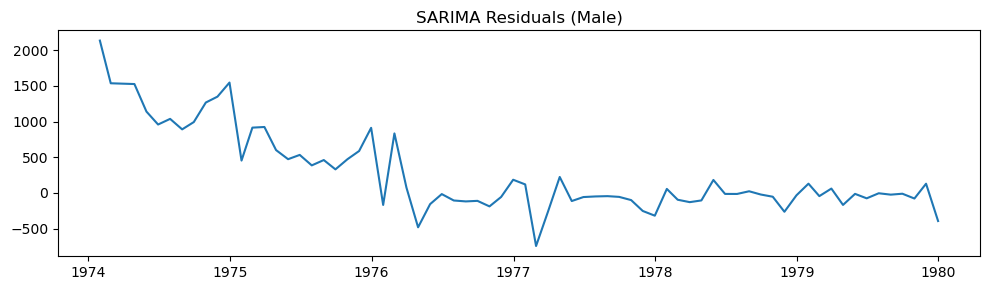

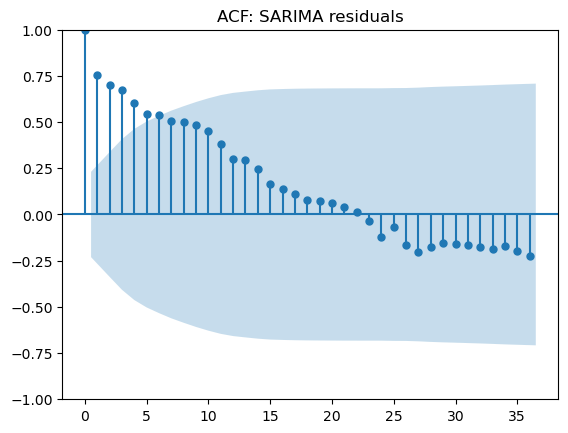

,lb_stat,lb_pvalue
12,290.770396,4.059951e-55
24,313.003440,4.000828e-52


In [16]:
sarima_resid = sarima_110.resid.dropna()

plt.figure(figsize=(10,3))
plt.plot(sarima_resid)
plt.title("SARIMA Residuals (Male)")
plt.tight_layout()
plt.show()

plot_acf(sarima_resid, lags=36)
plt.title("ACF: SARIMA residuals")
plt.show()

acorr_ljungbox(sarima_resid, lags=[12, 24], return_df=True)


### Interpretation
- If residual ACF has no spikes outside the band → residuals closer to white noise.
- If Ljung–Box p-values > 0.05 → cannot reject independence up to that lag.
This supports that SARIMA captured the serial dependence.


## 12. Forecasting (Next 12 Months)

### Why?
Forecasting demonstrates the practical use of SARIMA and illustrates uncertainty.


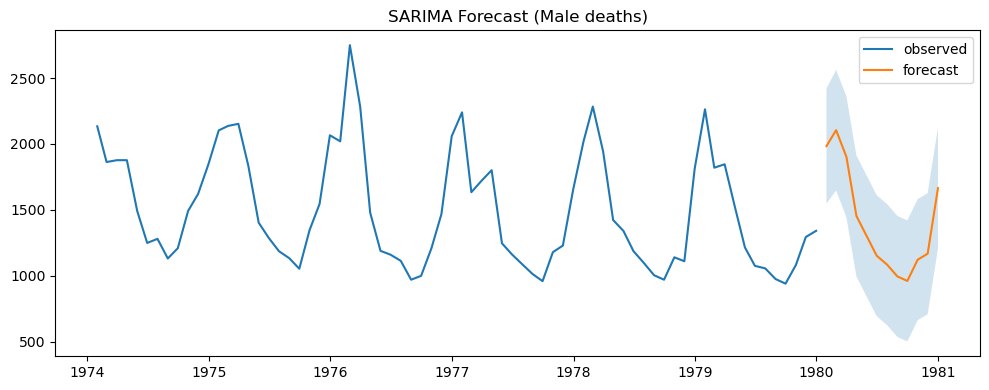

In [17]:
forecast_res = sarima_110.get_forecast(steps=12)
mean_fc = forecast_res.predicted_mean
ci = forecast_res.conf_int()

plt.figure(figsize=(10,4))
plt.plot(male, label="observed")
plt.plot(mean_fc.index, mean_fc.values, label="forecast")
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
plt.title("SARIMA Forecast (Male deaths)")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation
- Forecast continues the seasonal pattern into the future.
- Confidence band widens with time → increasing uncertainty.
- Forecast assumes the same seasonal dynamics continue.


## 13. Common Mistakes

- High R² ≠ white noise residuals
- Removing seasonality ≠ removing autocorrelation
- Always validate with residual ACF + Ljung–Box
- Do not over-difference


## 14. Finally now

You should be able to:
1) Separate deterministic seasonality from stochastic dependence  
2) Diagnose autocorrelation with lag scatter, ACF, PACF  
3) Use ADF/KPSS to reason about stationarity  
4) Fit and validate a SARIMA model  
5) Forecast with uncertainty bands
